# Traitement des données sur les animaux

In [1]:
# Import des librairies nécessaires

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling

Les photos des animaux sont stockées dans un dossier `raw-img`, qui contient plusieurs sous-dossiers avec des images de différents animaux :
- butterfly (papillons)
- cat (chats)
- chicken (poules)
- cow (vaches)
- dog (chiens)
- elephant (éléphants)
- horse (chevaux)
- sheep (moutons)
- spider (araignées)
- squirrel (écureuils)

In [2]:
# Répertoire contenant les dossiers des images
dataset_path = "raw-img"

# Création d'une liste contenant les noms des dossiers des images
class_names = os.listdir(dataset_path)
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [3]:
# Création d'un dataframe contenant les noms des images et leur label
data = []

for class_name in class_names:
    image_names = os.listdir(os.path.join(dataset_path, class_name))
    for image_name in image_names:
        data.append({
            "image": os.path.join(dataset_path, class_name, image_name),
            "category": class_name})
        
df = pd.DataFrame(data)
print(df)

                                                   image   category
0      raw-img\butterfly\e030b20928e90021d85a5854ee45...  butterfly
1      raw-img\butterfly\e030b20929e90021d85a5854ee45...  butterfly
2      raw-img\butterfly\e030b2092be90021d85a5854ee45...  butterfly
3      raw-img\butterfly\e030b2092ce90021d85a5854ee45...  butterfly
4      raw-img\butterfly\e030b2092de90021d85a5854ee45...  butterfly
...                                                  ...        ...
26174  raw-img\squirrel\OIP-_U7JiIoYjbWPqmmmmdsvJwHaF...   squirrel
26175  raw-img\squirrel\OIP-_VBkNQd_MZI4xoemUb-FtAHaE...   squirrel
26176  raw-img\squirrel\OIP-_WyHKgREia-4VijlL6DNswHaF...   squirrel
26177  raw-img\squirrel\OIP-_xFGMN0UbYduHdiXQ1maZAHaI...   squirrel
26178  raw-img\squirrel\OIP-_XkUFCI2duAyKDD9utKQzgHaF...   squirrel

[26179 rows x 2 columns]


<Axes: >

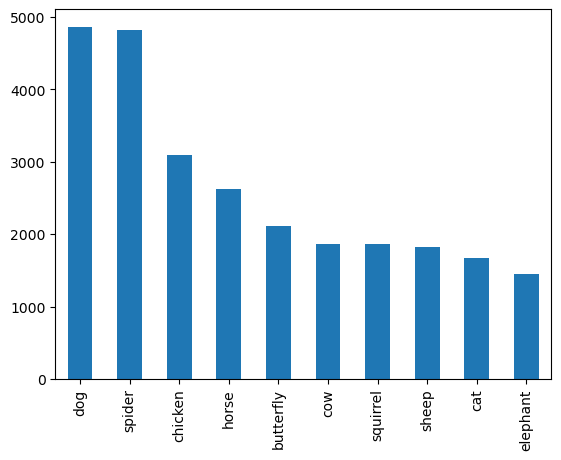

In [4]:
# Affichage des différentes catégories
df["category"].value_counts().plot.bar()

In [5]:
# Réduction du nombre d'images pour chaque catégorie, pour en garder seulement 500
train_df = df.groupby("category").head(500)
print(train_df)

                                                   image   category
0      raw-img\butterfly\e030b20928e90021d85a5854ee45...  butterfly
1      raw-img\butterfly\e030b20929e90021d85a5854ee45...  butterfly
2      raw-img\butterfly\e030b2092be90021d85a5854ee45...  butterfly
3      raw-img\butterfly\e030b2092ce90021d85a5854ee45...  butterfly
4      raw-img\butterfly\e030b2092de90021d85a5854ee45...  butterfly
...                                                  ...        ...
24812  raw-img\squirrel\OIP-DLuAMgbGGOGW0r49pIsMtgHaF...   squirrel
24813  raw-img\squirrel\OIP-DlVY-0x9uqexVnZY_1TXxgHaH...   squirrel
24814  raw-img\squirrel\OIP-DlwICIPtlrWDrdz6v-QVCQHaF...   squirrel
24815  raw-img\squirrel\OIP-DL_IigTXGyMfa6OEnyQF3QHaE...   squirrel
24816  raw-img\squirrel\OIP-dMd2HnsRjgUsYCAx2gZaVAHaK...   squirrel

[5000 rows x 2 columns]


Maintenant que notre dataframe est prêt, nous allons traiter les images pour les rendre utilisables par notre modèle.

In [6]:
# Définir la taille à laquelle toutes les images seront redimensionnées
IMG_SIZE = 224

def load_and_preprocess_image(image_path: str):
    """Charger et prétraiter une image
    
    Args:
        image_path (str): Chemin de l'image à charger
    """
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    return image

In [7]:
# Charger toutes les images et les étiquettes
images = []
labels = []

for index, row in train_df.iterrows():
    img = load_and_preprocess_image(row["image"])
    images.append(img)
    labels.append(row["category"])

In [8]:
# Conversion des listes en tableaux numpy
images = np.array(images)
labels = np.array(labels)

In [9]:
# Transformation des étiquettes en valeurs numériques
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32

train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [11]:
validation_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [12]:
class_names = train_dataset.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


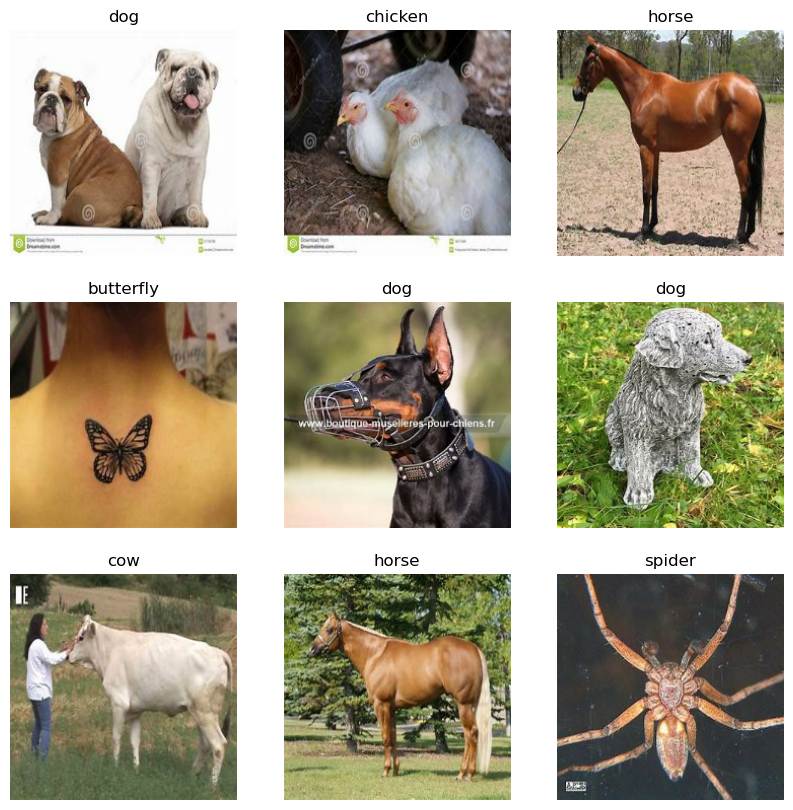

In [13]:
# # Visualisation des images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:
# Application de la normalisation aux images
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Création du modèle

model = Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(len(class_names))
])

model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
655/655 [==============================] - 678s 1s/step - loss: 1.6091 - accuracy: 0.4428 - val_loss: 1.3242 - val_accuracy: 0.5440
Epoch 2/10
655/655 [==============================] - 555s 846ms/step - loss: 1.0773 - accuracy: 0.6368 - val_loss: 1.2906 - val_accuracy: 0.5727
Epoch 3/10
655/655 [==============================] - 552s 843ms/step - loss: 0.7365 - accuracy: 0.7532 - val_loss: 1.4646 - val_accuracy: 0.5677
Epoch 4/10
655/655 [==============================] - 546s 834ms/step - loss: 0.4663 - accuracy: 0.8441 - val_loss: 1.6801 - val_accuracy: 0.5715
Epoch 5/10
655/655 [==============================] - 543s 829ms/step - loss: 0.2787 - accuracy: 0.9062 - val_loss: 1.9699 - val_accuracy: 0.5826
Epoch 6/10
655/655 [==============================] - 549s 837ms/step - loss: 0.1825 - accuracy: 0.9399 - val_loss: 2.1260 - val_accuracy: 0.5903
Epoch 7/10
655/655 [==============================] - 554s 845ms/step - loss: 0.1146 - accuracy: 0.9601 - val_loss: 2.4958 - va

In [17]:
# Sauvegarde du modèle
model.save("animal_classifier_model.h5")

Maintenant que le modèle est prêt, il est temps de le tester sur des données !

In [18]:
def get_random_image_path(base_path: str, class_names: list) -> str:
    """Récupérer le chemin d'une image aléatoire
    
    Args:
        base_path (str): Chemin du dossier contenant les images
        class_names (list): Liste des noms des catégories"""
    category = np.random.choice(class_names)
    image_name = np.random.choice(os.listdir(os.path.join(base_path, category)))

    return os.path.join(dataset_path, category, image_name)

In [27]:
# Chargement du modèle
# model = tf.keras.models.load_model("animal_classifier_model_224x.h5")

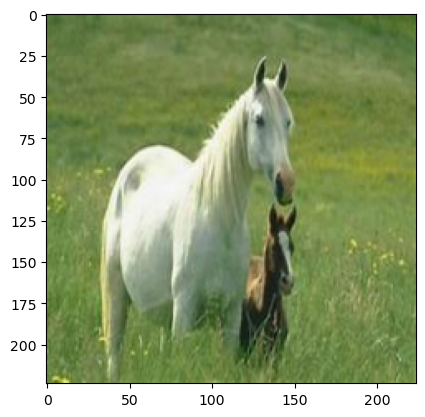

In [28]:
# Chargement d'une image aléatoire
random_image_path = get_random_image_path(dataset_path, class_names)

# Chargement et prétraitement de l'image
img = load_and_preprocess_image(random_image_path)
plt.imshow(img)

In [29]:
# Ajout d'une dimension à l'image
img = np.expand_dims(img, axis=0)

# Prédiction de l'image
predictions = model.predict(img)

1/1 [==============================] - 0s 118ms/step


In [30]:
# Récupération de la catégorie prédite
predicted_category = class_names[np.argmax(predictions)]

print(f"Catégorie prédite: {predicted_category}")

Catégorie prédite: horse


In [31]:
# Affichage des probabilités de chaque catégorie
for category, proba in zip(class_names, predictions[0]):
    print(f"{category}: {proba * 100:.2f}%")

butterfly: -323.78%
cat: -846.73%
chicken: -670.71%
cow: -491.77%
dog: -114.62%
elephant: -486.29%
horse: 739.72%
sheep: 1.21%
spider: -194.02%
squirrel: 10.00%


<BarContainer object of 10 artists>

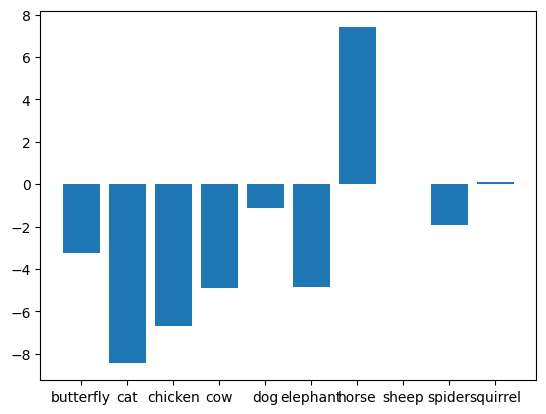

In [32]:
# Affichage des probabilités sous forme de diagramme à barres
plt.bar(class_names, predictions[0])

In [25]:
# Vérification de la version de TensorFlow
print(tf.__version__)

2.11.0
